# Titanic Classification
Riley Wheadon <br>
December 26th, 2022

In [876]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

titanic = pd.read_csv("raw/train.csv")
test = pd.read_csv("raw/test.csv")

## Preliminary Analysis

In [877]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [878]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Feature Engineering
- Get titles from Name (DONE)
- Bin age (DONE)
- Combine SibSp and Parch into a single variable (DONE)
- Remove Ticket (DONE)
- Fare = Log(Fare) (DONE)
- Group Cabin into M, Other (DONE)

In [879]:
#Print the Shape and Count Null Values
def overview():
    print(f"""
TRAINING SET:
{titanic.shape}
{titanic.isna().sum()}

TESTING SET:
{test.shape}
{test.isna().sum()}
    """)

overview()


TRAINING SET:
(891, 12)
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

TESTING SET:
(418, 11)
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
    


In [880]:
for df in [titanic, test]:
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Cabin'] = df['Cabin'].fillna('M')
    
titanic['Embarked'] = titanic['Embarked'].fillna('C')
test['Fare'] = test['Fare'].fillna(5)

<AxesSubplot:xlabel='Age', ylabel='count'>

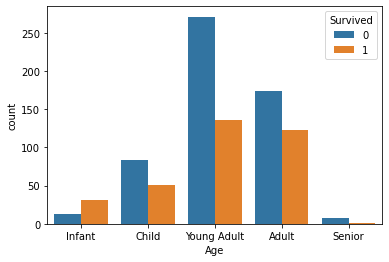

In [881]:
titanic['Age'] = pd.cut(
    titanic.Age, 
    bins = [-1,5,20,30,65,99],
    labels = ['Infant', 'Child', 'Young Adult', 'Adult', 'Senior'])

sns.countplot(data = titanic, x = 'Age', hue = 'Survived')

<AxesSubplot:xlabel='Title', ylabel='count'>

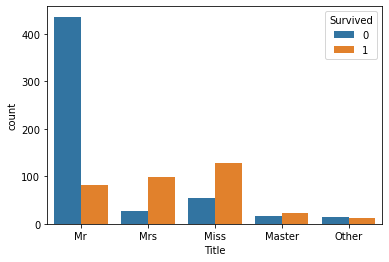

In [882]:
titanic['Title'] = titanic.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

for row in titanic.index:
    if titanic["Title"][row] not in ['Mr', 'Mrs', 'Miss', 'Master']:
        titanic.at[row, "Title"] = "Other"
        
titanic

sns.countplot(data = titanic, x = 'Title', hue = 'Survived')

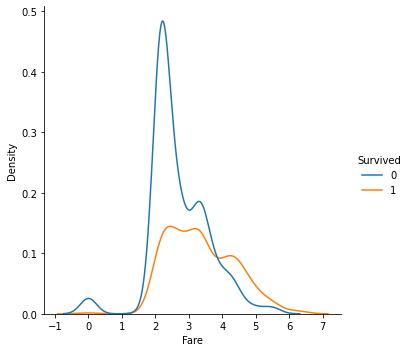

In [883]:
titanic['Fare'] = titanic['Fare'].transform(lambda x: x + 1)
titanic['Fare'] = np.log(titanic['Fare'])

sns.displot(titanic, x="Fare", kind="kde", hue = "Survived")

<AxesSubplot:xlabel='Company', ylabel='count'>

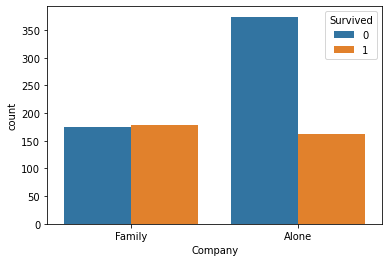

In [884]:
for row in titanic.index:
    if titanic["SibSp"][row] == 0 and titanic["Parch"][row] == 0:
        titanic.at[row, "SibSp"] = "Alone"
    else:
        titanic.at[row, "SibSp"] = "Family"
        
titanic = titanic.drop("Parch", axis = 1)
titanic.rename(columns = {'SibSp':'Company'}, inplace = True)
  
sns.countplot(data = titanic, x = 'Company', hue = 'Survived')

<AxesSubplot:xlabel='Cabin', ylabel='count'>

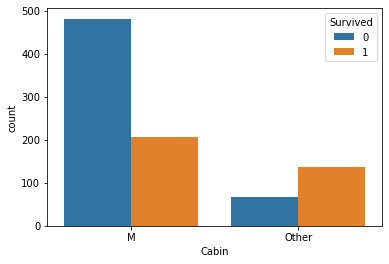

In [885]:
titanic['Cabin'] = titanic['Cabin'].where(titanic['Cabin'].isin(['M']), 'Other')
sns.countplot(data = titanic, x = 'Cabin', hue = 'Survived')

In [886]:
titanic = titanic.drop(['Name', 'Ticket'], axis = 1)
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,Company,Fare,Cabin,Embarked,Title
0,1,0,3,male,Young Adult,Family,2.110213,M,S,Mr
1,2,1,1,female,Adult,Family,4.280593,Other,C,Mrs
2,3,1,3,female,Young Adult,Alone,2.188856,M,S,Miss
3,4,1,1,female,Adult,Family,3.990834,Other,S,Mrs
4,5,0,3,male,Adult,Alone,2.202765,M,S,Mr


In [887]:
def preprocessing(df):
    df['Age'] = pd.cut(
        df.Age, 
        bins = [-1,5,20,30,65,99],
        labels = ['Infant', 'Child', 'Young Adult', 'Adult', 'Senior']
    )
    
    df['Title'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

    for row in df.index:
        if df["Title"][row] not in ['Mr', 'Mrs', 'Miss', 'Master']:
            df.at[row, "Title"] = "Other"
    
    df['Fare'] = df['Fare'].transform(lambda x: x + 1)
    df['Fare'] = np.log(df['Fare'])

    for row in df.index:
        if df["SibSp"][row] == 0 and df["Parch"][row] == 0:
            df.at[row, "SibSp"] = "Alone"
        else:
            df.at[row, "SibSp"] = "Family"
        
    df = df.drop("Parch", axis = 1)
    df.rename(columns = {'SibSp':'Company'}, inplace = True)
    df['Cabin'] = df['Cabin'].where(df['Cabin'].isin(['M']), 'Other')
    df = df.drop(['Name', 'Ticket'], axis = 1)
    
    return df

test = preprocessing(test)
test

,PassengerId,Pclass,Sex,Age,Company,Fare,Cabin,Embarked,Title
0,892,3,male,Adult,Alone,2.178064,M,Q,Mr
1,893,3,female,Adult,Family,2.079442,M,S,Mrs
2,894,2,male,Adult,Alone,2.369075,M,Q,Mr
3,895,3,male,Young Adult,Alone,2.268252,M,S,Mr
4,896,3,female,Young Adult,Family,2.586824,M,S,Mrs
...,...,...,...,...,...,...,...,...,...
413,1305,3,male,Adult,Alone,2.202765,M,S,Mr
414,1306,1,female,Adult,Alone,4.699571,Other,C,Other
415,1307,3,male,Adult,Alone,2.110213,M,S,Mr
416,1308,3,male,Adult,Alone,2.202765,M,S,Mr


In [888]:
titanic.to_csv('features/train_features.csv', index = False)
test.to_csv('features/test_features.csv', index = False)